Taken from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

In [12]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

scanpy==1.8.0 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_all.h5ad')
adata

AnnData object with n_obs × n_vars = 300353 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

## Integrating private dataset

In [4]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="patient",
    subset=True
)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="patient")

INFO     Using batches from adata.obs["patient"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 300353 cells, 2000 genes, 4       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [7]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [ ]:
vae.train()

INFO     KL warmup for 400 epochs                                                            


Output()

In [9]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [10]:
%%time
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

2021-10-17 21:39:46.373230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 21:39:46.373482: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
import math
adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
adata.obs['infected'] = adata.obs['infected'].astype('category')

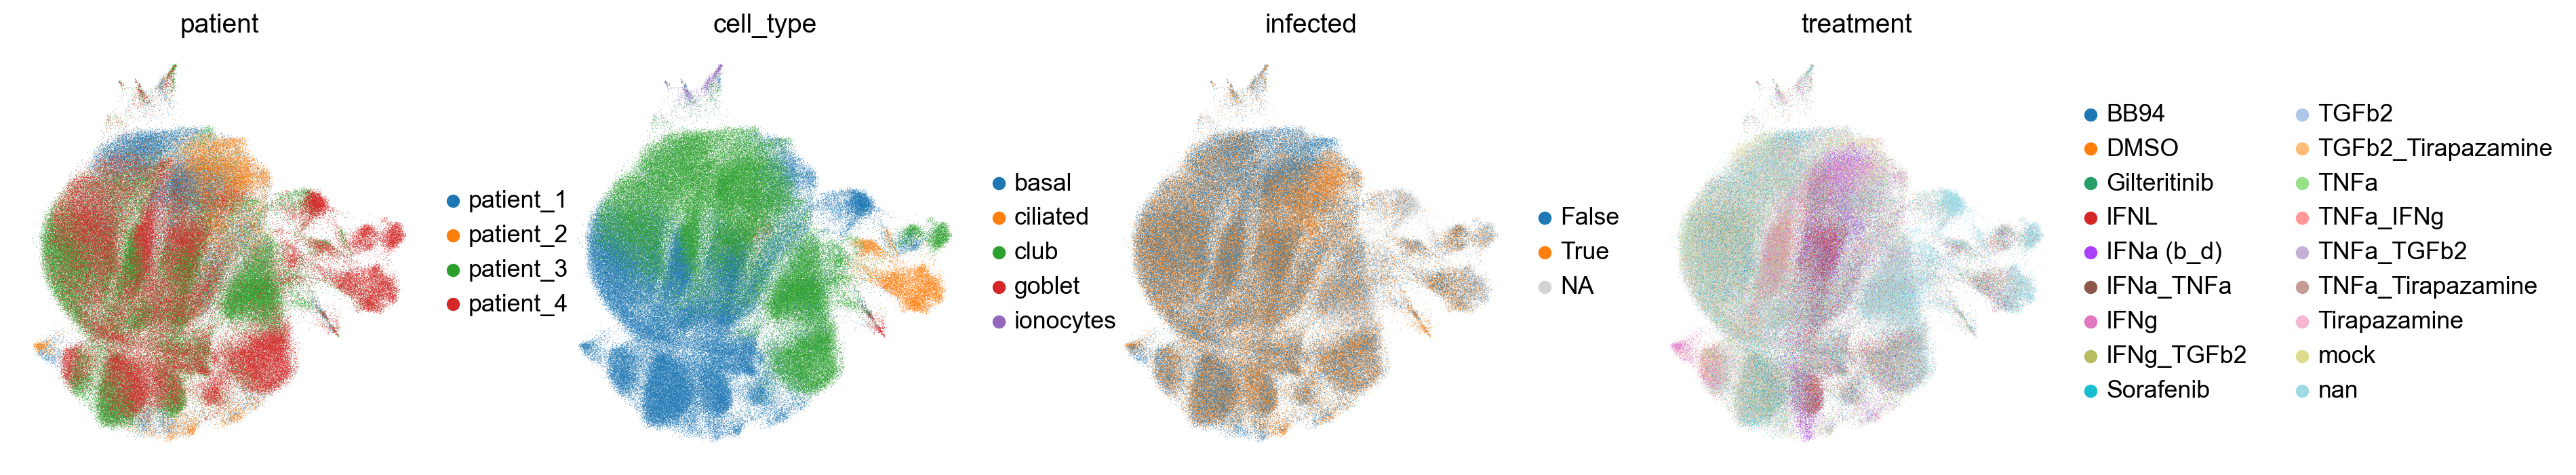

In [19]:
sc.pl.umap(adata, color=['patient', 'cell_type', 'infected', 'treatment'])

In [32]:
import json
json.dumps(adata.uns['_scvi'])

TypeError: Object of type Index is not JSON serializable

In [31]:
adata.uns['_scvi']

{'scvi_version': None,
 'categorical_mappings': {'_scvi_batch': {'original_key': 'patient',
   'mapping': Index(['patient_1', 'patient_2', 'patient_3', 'patient_4'], dtype='object')},
  '_scvi_labels': {'original_key': '_scvi_labels',
   'mapping': Int64Index([0], dtype='int64')}},
 'use_raw': False,
 'data_registry': {'X': {'attr_name': 'layers', 'attr_key': 'counts'},
  'batch_indices': {'attr_name': 'obs', 'attr_key': '_scvi_batch'},
  'local_l_mean': {'attr_name': 'obs', 'attr_key': '_scvi_local_l_mean'},
  'local_l_var': {'attr_name': 'obs', 'attr_key': '_scvi_local_l_var'},
  'labels': {'attr_name': 'obs', 'attr_key': '_scvi_labels'}},
 'summary_stats': {'n_batch': 4,
  'n_cells': 300353,
  'n_genes': 2000,
  'n_labels': 1,
  'n_proteins': 0}}

In [21]:
sc.write('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211001_annot_patient_integrated.h5ad', adata)

NotImplementedError: Failed to write value for uns/_scvi/categorical_mappings/_scvi_batch/mapping, since a writer for type <class 'pandas.core.indexes.base.Index'> has not been implemented yet.

Above error raised while writing key 'uns/_scvi/categorical_mappings/_scvi_batch/mapping' of <class 'h5py._hl.files.File'> from /.

AttributeError: module 'scvi' has no attribute 'version'